### Machine Learning Project - **Alice DEVILDER**

# Twitter Climate Change Sentiment Analysis

This project focuses on the sentiment analysis of tweets related to climate change by building and comparing machine learning models to classify whether a person believes in climate change based on novel tweet data. 
The dataset used for this analysis was collected as part of a project funded by *a Canada Foundation for Innovation JELF Grant* awarded to **Chris Bauch** at the *University of Waterloo*.  
It corresponds to the [Twitter Climate Change Sentiment Dataset](https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset) from Kaggle .

### Some context

Climate change remains a topic of significant global concern, prompting ongoing discussions and debates on social media platforms like Twitter. With the proliferation of climate-related content online, distinguishing between different perspectives and attitudes towards climate change is crucial for understanding public sentiment and informing policy decisions.

Twitter serves as a valuable source of real-time data reflecting diverse viewpoints on climate change, ranging from support for climate action to skepticism or denial of its existence. By leveraging machine learning techniques, this project aims to analyze and classify tweet sentiments to discern whether individuals express belief or disbelief in climate change.

In this dynamic digital landscape, the ability to accurately classify tweet sentiments offers valuable insights into public perceptions and attitudes towards climate change. By building and comparing machine learning models, this project seeks to enhance our understanding of the nuanced discourse surrounding climate change on social media platforms like Twitter.

### About Dataset

The dataset aggregates tweets pertaining to climate change collected between *April 27, 2015*, and *February 21, 2018*. A total of **43,943 tweets** were annotated for sentiment analysis. Each tweet is independently labelled by three reviewers, and only tweets where all three reviewers agreed on the sentiment are included in the dataset.

Each tweet is labelled with one of the following classes:

* **2 (News):** The tweet links to factual news about climate change.
* **1 (Pro):** The tweet supports the belief of man-made climate change.
* **0 (Neutral):** The tweet neither supports nor refutes the belief of man-made climate change.
* **-1 (Anti):** The tweet does not believe in man-made climate change.

Moreover, the dataset includes three columns:

**sentiment:** The sentiment label of the tweet.  
**message:** The text content of the tweet.  
**tweetid:** The unique identifier of the tweet.

### Project Objective

The project objective is to build and compare machine learning models to classify whether a person believes in climate change based on novel tweet data. By leveraging the dataset collected as part of the Canada Foundation for Innovation JELF Grant, the aim is to develop robust classification algorithms that accurately distinguish between different perspectives on climate change expressed in tweets. The project seeks to evaluate the performance of various machine learning techniques and identify the most effective model for sentiment analysis of climate change-related tweets on Twitter.

## Import librairies and dataset

In [1]:
# %pip install transformers
# %pip install gensim
# %pip install wordcloud

In [47]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from transformers import DistilBertTokenizerFast, DistilBertModel
import torch
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

my_seed = 1
rng = np.random.default_rng(seed=my_seed) # random number generator

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alice\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alice\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alice\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We can first import the dataset and how it looks like.

In [3]:
df = pd.read_csv('twitter_sentiment_data.csv')

## 1. Data Cleansing 

Let's see how the dataset looks like using ```df.head(10)```.

In [4]:
df.head(10)

sentiment                                            message  \
0         -1  @tiniebeany climate change is an interesting h...   
1          1  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2          1  Fabulous! Leonardo #DiCaprio's film on #climat...   
3          1  RT @Mick_Fanning: Just watched this amazing do...   
4          2  RT @cnalive: Pranita Biswasi, a Lutheran from ...   
5          0  Unamshow awache kujinga na iko global warming ...   
6          2  RT @cnalive: Pranita Biswasi, a Lutheran from ...   
7          2  RT @CCIRiviera: Presidential Candidate #Donald...   
8          0  RT @AmericanIndian8: Leonardo DiCaprio's clima...   
9          1  #BeforeTheFlood Watch #BeforeTheFlood right he...   

              tweetid  
0  792927353886371840  
1  793124211518832641  
2  793124402388832256  
3  793124635873275904  
4  793125156185137153  
5  793125429418815489  
6  793125430236684289  
7  793126558688878592  
8  793127097854197761  
9  793127346106753028

Then we can also have some information about the dataset by calling ```df.info```, such as ncol, nrow, nbr missing values, dtypes.

In [5]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


This dataset has **43943** entries and **3** columns: **sentiment**, **message** and **tweetid**.

Let's see now if there are some nan values and duplicates. 

In [6]:
pd.isnull(df).sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [7]:
print("There are", df.duplicated(['message', 'sentiment']).sum(), "duplicates in the dataset. So we will remove them. \n")

df = df.drop_duplicates(['message','sentiment'])
print("Duplicates removed. Now, the dataset has", df.shape[0], "rows. \n")

# Check if there are messages with the same content but different sentiment
print("Checking for messages with the same content but different sentiment... \n")

duplicates = df[df.duplicated(['message'], keep=False)].sort_values(by=['message'])
duplicates

There are 2902 duplicates in the dataset. So we will remove them. 

Duplicates removed. Now, the dataset has 41041 rows. 

Checking for messages with the same content but different sentiment... 



sentiment                                            message  \
55             2  RT @ABCPolitics: .@realDonaldTrump vows to can...   
168            1  RT @ABCPolitics: .@realDonaldTrump vows to can...   
7122           0  RT @AngelicaJoy__: It's so nice out LOL global...   
7817           1  RT @AngelicaJoy__: It's so nice out LOL global...   
4438           0  RT @AssaadRazzouk: In the new new world, China...   
4482           1  RT @AssaadRazzouk: In the new new world, China...   
129            0  RT @COP22: In 4 days the most ambitious climat...   
307            1  RT @COP22: In 4 days the most ambitious climat...   
2012           2  RT @Channel4News: .@LeoDiCaprio calls on citiz...   
2056           1  RT @Channel4News: .@LeoDiCaprio calls on citiz...   
3863           0  RT @JeffreyGuterman: #Trump has selected Myron...   
4230           1  RT @JeffreyGuterman: #Trump has selected Myron...   
1015           0  RT @Uniocracy: They'll tell you theyre doing i...   
8533          -1  RT @Uniocracy: They'll tell you theyre doing i...   
2735           0  RT @realDonaldTrump: Where the hell is global ...   
10876         -1  RT @realDonaldTrump: Where the hell is global ...   

                  tweetid  
55     793151228498866176  
168    793216460524888064  
7122   800125205653897216  
7817   802590953777364992  
4438   797651999395368960  
4482   797706914226376704  
129    793197191443603456  
307    793308788627570688  
2012   795560731609546752  
2056   795619506844336128  
3863   797100540853358592  
4230   797399603708456960  
1015   793913627552120833  
8533   806723164554207234  
2735   796293320783826945  
10876  818685360792289280

As they don't have the sentiment, if we drop these duplicates, we will loose some information about the sentiment. Therefore we will keep them.

The dataset is clean! There is no null value and no duplicate. We can now move on to the preprocessing part. 

### Some analysis of the dataset

In [8]:
df.sample(10)

sentiment                                            message  \
23606          0  RT @brady_bw: Do you believe that (negative) c...   
8686          -1  @JunkScience the fraud &amp; cult of 'climate ...   
13819          0               @ScottFisherFOX7 wats global warming   
7895           1  RT @ManuelQ: .@Reince says @realDonaldTrump st...   
10470         -1  RT @SteveSGoddard: I lived through the global ...   
55             2  RT @ABCPolitics: .@realDonaldTrump vows to can...   
27273          1  RT @ClimateReality: Yes, science indicates hur...   
8242           0  RT @cracked: So glad Gore and Trump could find...   
11806          2  RT @johanntasker: Defra ‘tried to bury’ alarmi...   
27953          1  RT @WePowerN: '... we have to do something abo...   

                  tweetid  
23606  879736551076384768  
8686   807080179088560128  
13819  836756201400643584  
7895   803311324751085572  
10470  815787190701723649  
55     793151228498866176  
27273  910509757231853570  
8242   805949121232306177  
11806  823527347349491712  
27953  920346215245426689

Looking at a sample of 10 rows of the data we can observe and make the following assumptions:

* Some tweets contain twitter handles (e.g @IEA), numbers (e.g year 1995), hashtags (e.g #BeforeTheFlood) and re-tweets (RT).
* Some tweets contain names of ogarnisations, continents and countries.
* New lines are represented by '\n' in the tweet string.
* The tweets may contain URLs.
* The tweets may contain percetages, money symbols and emoticons.

Let's check that.

In [9]:
print("Number of @ contained in the tweets:", df['message'].str.contains('@').sum())
print("Number of # contained in the tweets:", df['message'].str.contains('#').sum(), "\n")

print("Number of url contained in the tweets:", df['message'].str.contains('http').sum(),"and number of www contained:", df['message'].str.contains('www').sum())
print("Number of new lines contained in the tweets:", df['message'].str.contains('\n').sum())
print("Number of re-tweets (RT) contained in the tweets:", df['message'].str.contains('RT').sum(), "\n")

# Check if there are emojis in the tweets
def find_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

emojis = df['message'].apply(find_emojis)
emojis = [e for e in emojis if e != []]
print("There are", len(emojis),"emojis in the tweets such as:", emojis[:10])


Number of @ contained in the tweets: 28300
Number of # contained in the tweets: 7931 

Number of url contained in the tweets: 24665 and number of www contained: 13
Number of new lines contained in the tweets: 3794
Number of re-tweets (RT) contained in the tweets: 22348 



There are 1088 emojis in the tweets such as: [['👀', '👍🏼'], ['👇👇'], ['✔︎', '✔︎', '✔︎', '✔︎'], ['☄', '⛱'], ['😳'], ['🌍', '💀'], ['🖐'], ['😮'], ['😳'], ['👏🏽', '👏🏽', '👏🏽']]


### Before doing some preprocessing, let's see the **Distribution Of The Target Variable**

In [10]:
# Create class distribution dataframe
class_distribution = pd.DataFrame(list(df['sentiment'].value_counts()), index = ['Pro', 'News', 'Neutral', 'Anti'], columns = ['Count'])
class_distribution.head()
    

Count
Pro      20605
News      9073
Neutral   7505
Anti      3858

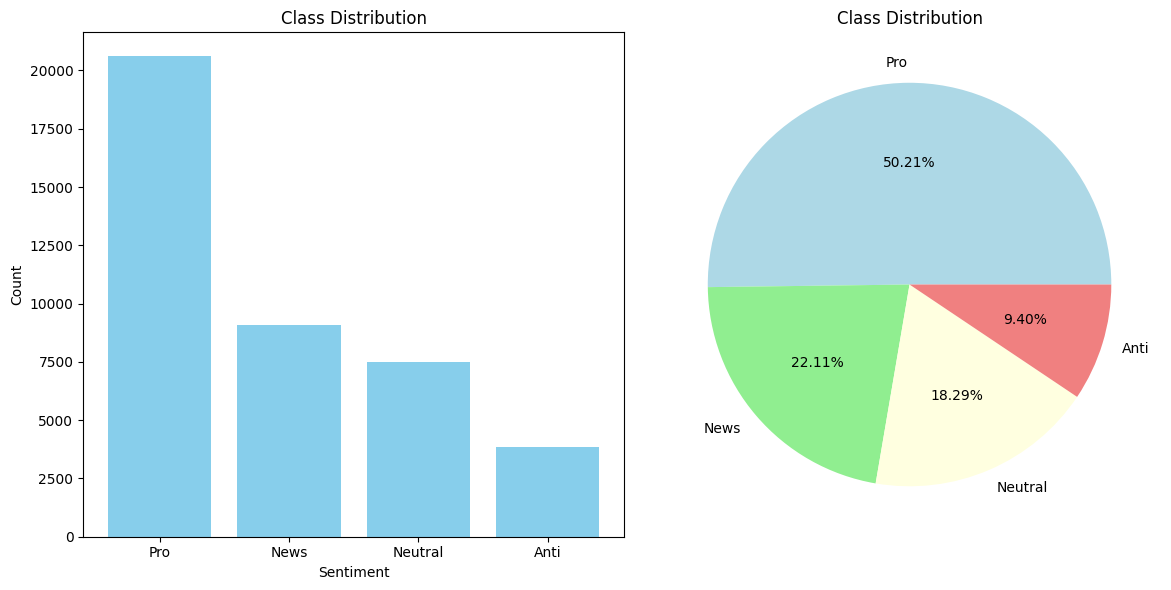

In [11]:
# Plot class distribution
plt.figure(figsize=(12, 6))

# Create left subplot for bar plot
plt.subplot(1, 2, 1)
plt.bar(class_distribution.index, class_distribution['Count'], color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Create right subplot for pie plot
plt.subplot(1, 2, 2)
plt.pie(class_distribution['Count'], labels=class_distribution.index, autopct='%1.2f%%', colors=['lightblue', 'lightgreen', 'lightyellow', 'lightcoral'])
plt.title('Class Distribution')

plt.tight_layout()
plt.show()

We can notice that amongst this dataset, half of the tweeter messages are classified as **Pro** which means that half of the tweets supports the belief of man-made climate change.

### Extrat the **Handles** to see their impact on the sentiment analysis
A Twitter handle is the username that appears at the end of your unique Twitter URL. Twitter handles appear after the @ sign in your profile URL and it must be unique to your account. A Twitter name, on the other hand, is simply there to help people find the company they're looking for.

In [12]:
def extract_handles(x):
    handles = []
    for i in x:
        h = re.findall(r'@(\w+)', i)
        handles.append(h)

    handles = sum(handles, [])
    frequency = nltk.FreqDist(handles)
    
    handle_df = pd.DataFrame({'handle': list(frequency.keys()), 'count': list(frequency.values())})
    handle_df = handle_df.nlargest(15, columns="count")

    return handle_df

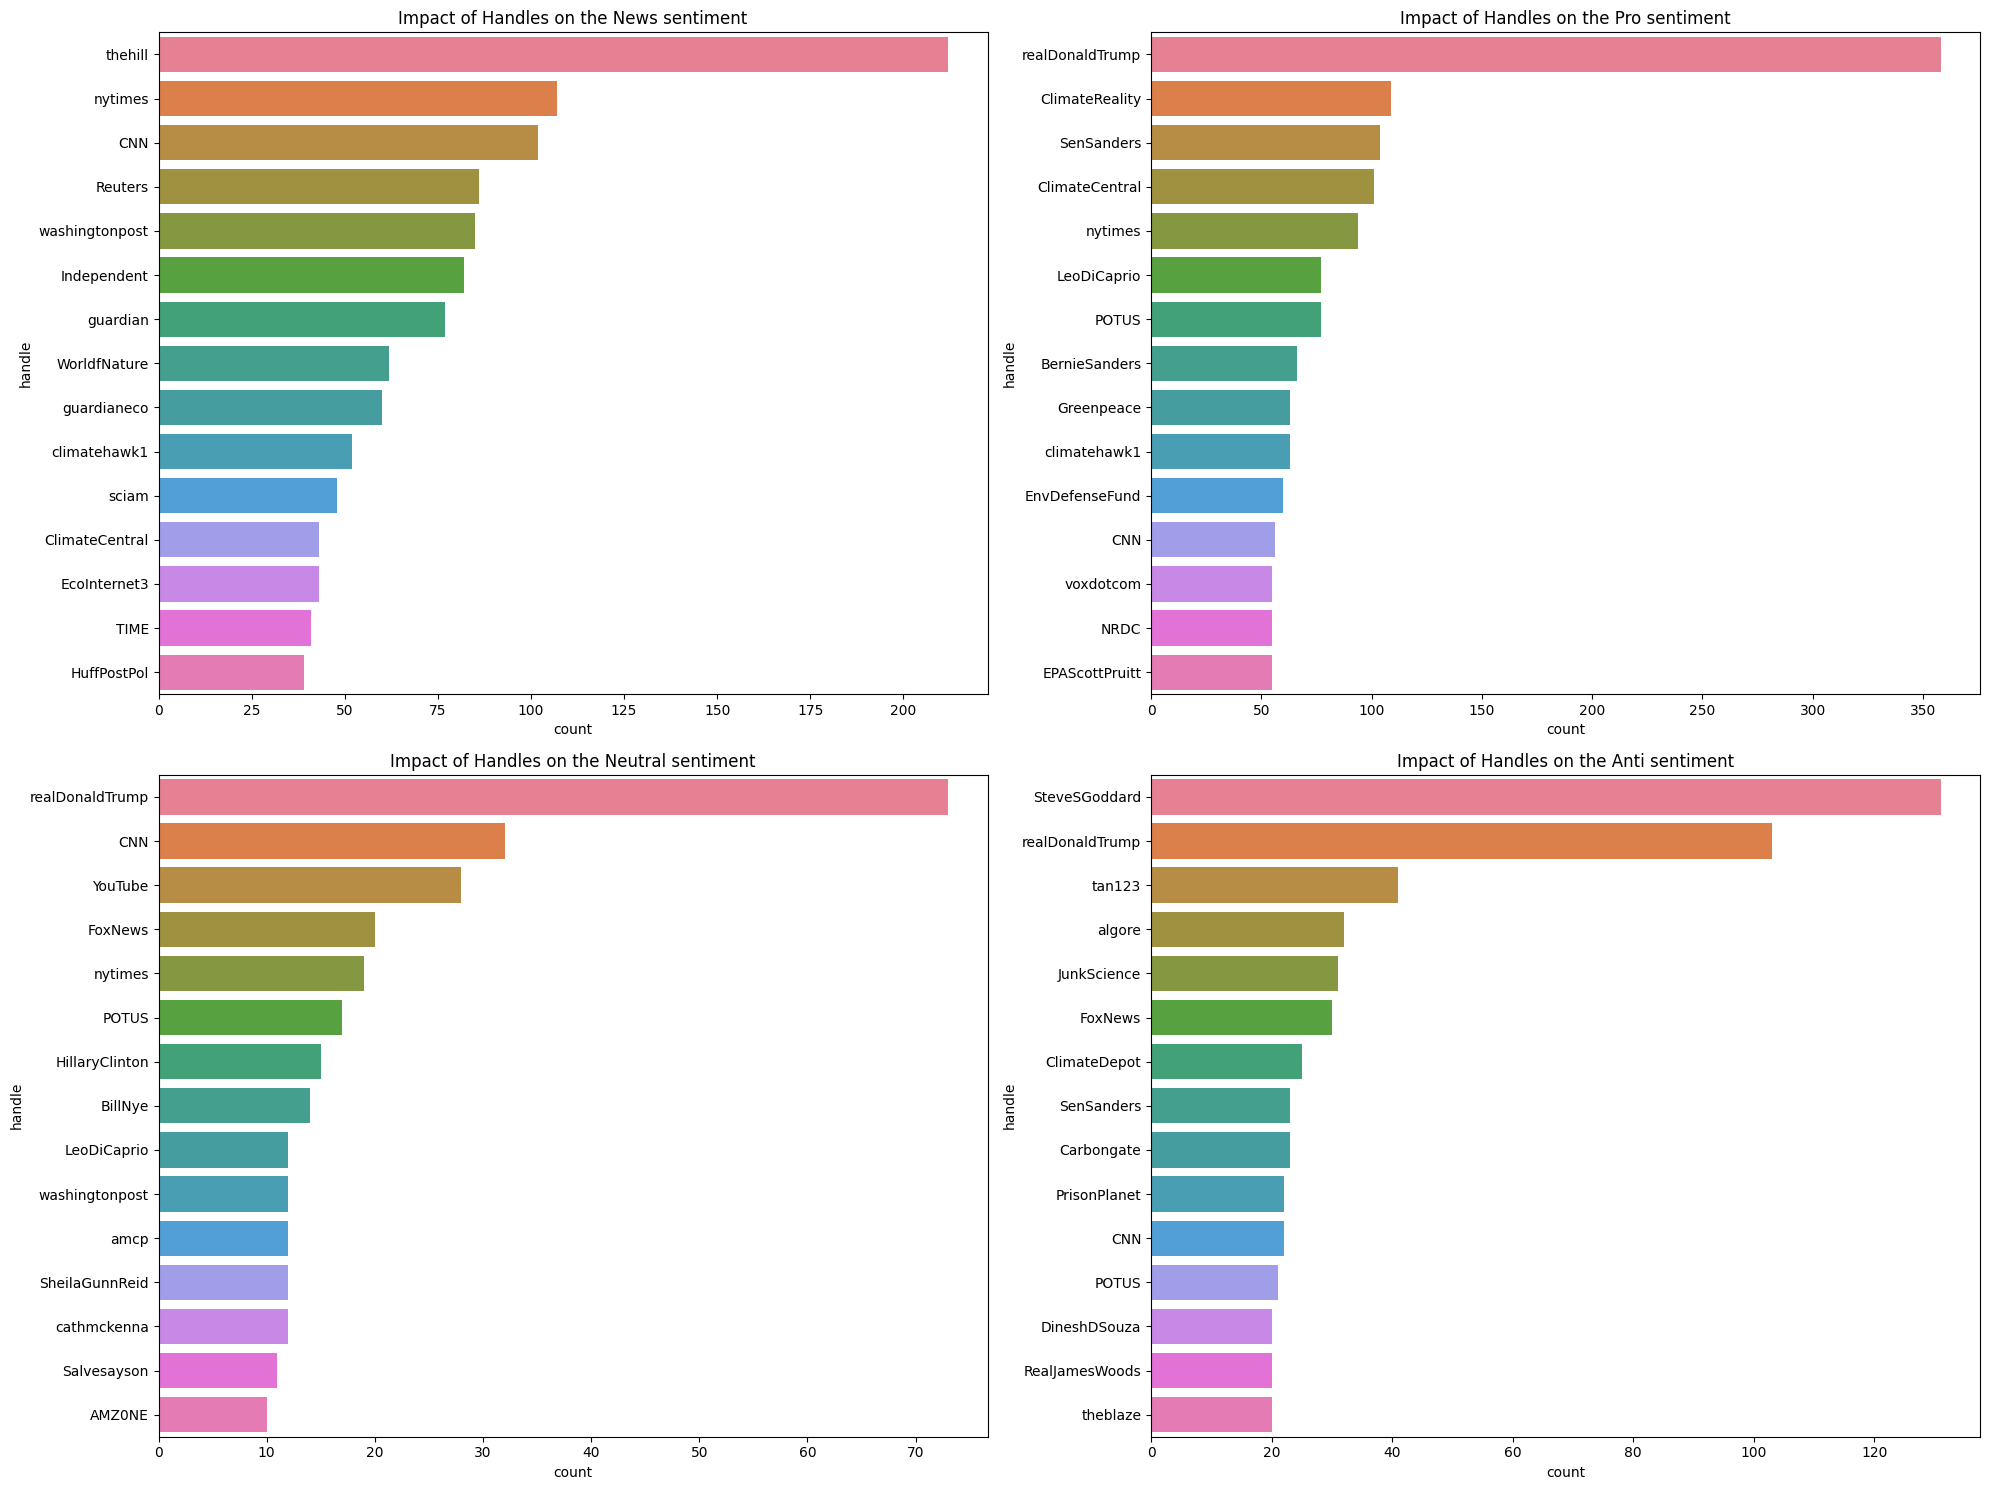

In [13]:
# Extracting handles from tweets
news_handles = extract_handles(df['message'][df['sentiment'] == 2])

pro_handles = extract_handles(df['message'][df['sentiment'] == 1])

neutral_handles = extract_handles(df['message'][df['sentiment'] == 0])

anti_handles = extract_handles(df['message'][df['sentiment'] == -1])

# Visualising the Handles
full_title = ['Impact of Handles on the News sentiment',
              'Impact of Handles on the Pro sentiment',
              'Impact of Handles on the Neutral sentiment',
              'Impact of Handles on the Anti sentiment']


# Barplot of the handles for each category
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
for i, j in enumerate([news_handles, pro_handles, neutral_handles, anti_handles]):
    row = i // 2
    col = i % 2
    sns.barplot(x='count', y='handle', data=j, ax=axes[row, col], palette='husl', hue='handle', legend=False)
    axes[row, col].set_title(full_title[i])
    
plt.tight_layout()
plt.show()

#### **Comments:**

### Extrat **Hashtags** to see their impact on the sentiment analysis

People use the hashtag symbol (#) before a relevant keyword or phrase in their Tweet to categorize those Tweets and help them show more easily in Twitter search. Clicking or tapping on a hashtagged word in any message shows you other Tweets that include that hashtag. Hashtags can be included anywhere in a Tweet.

In [14]:
def extract_hashtags(x):
    hashtags = []
    for i in x:
        h = re.findall(r'#(\w+)', i)
        hashtags.append(h)

    hashtags = sum(hashtags, [])
    frequency = nltk.FreqDist(hashtags)
    
    hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()), 'count': list(frequency.values())})
    hashtag_df = hashtag_df.nlargest(15, columns="count")

    return hashtag_df

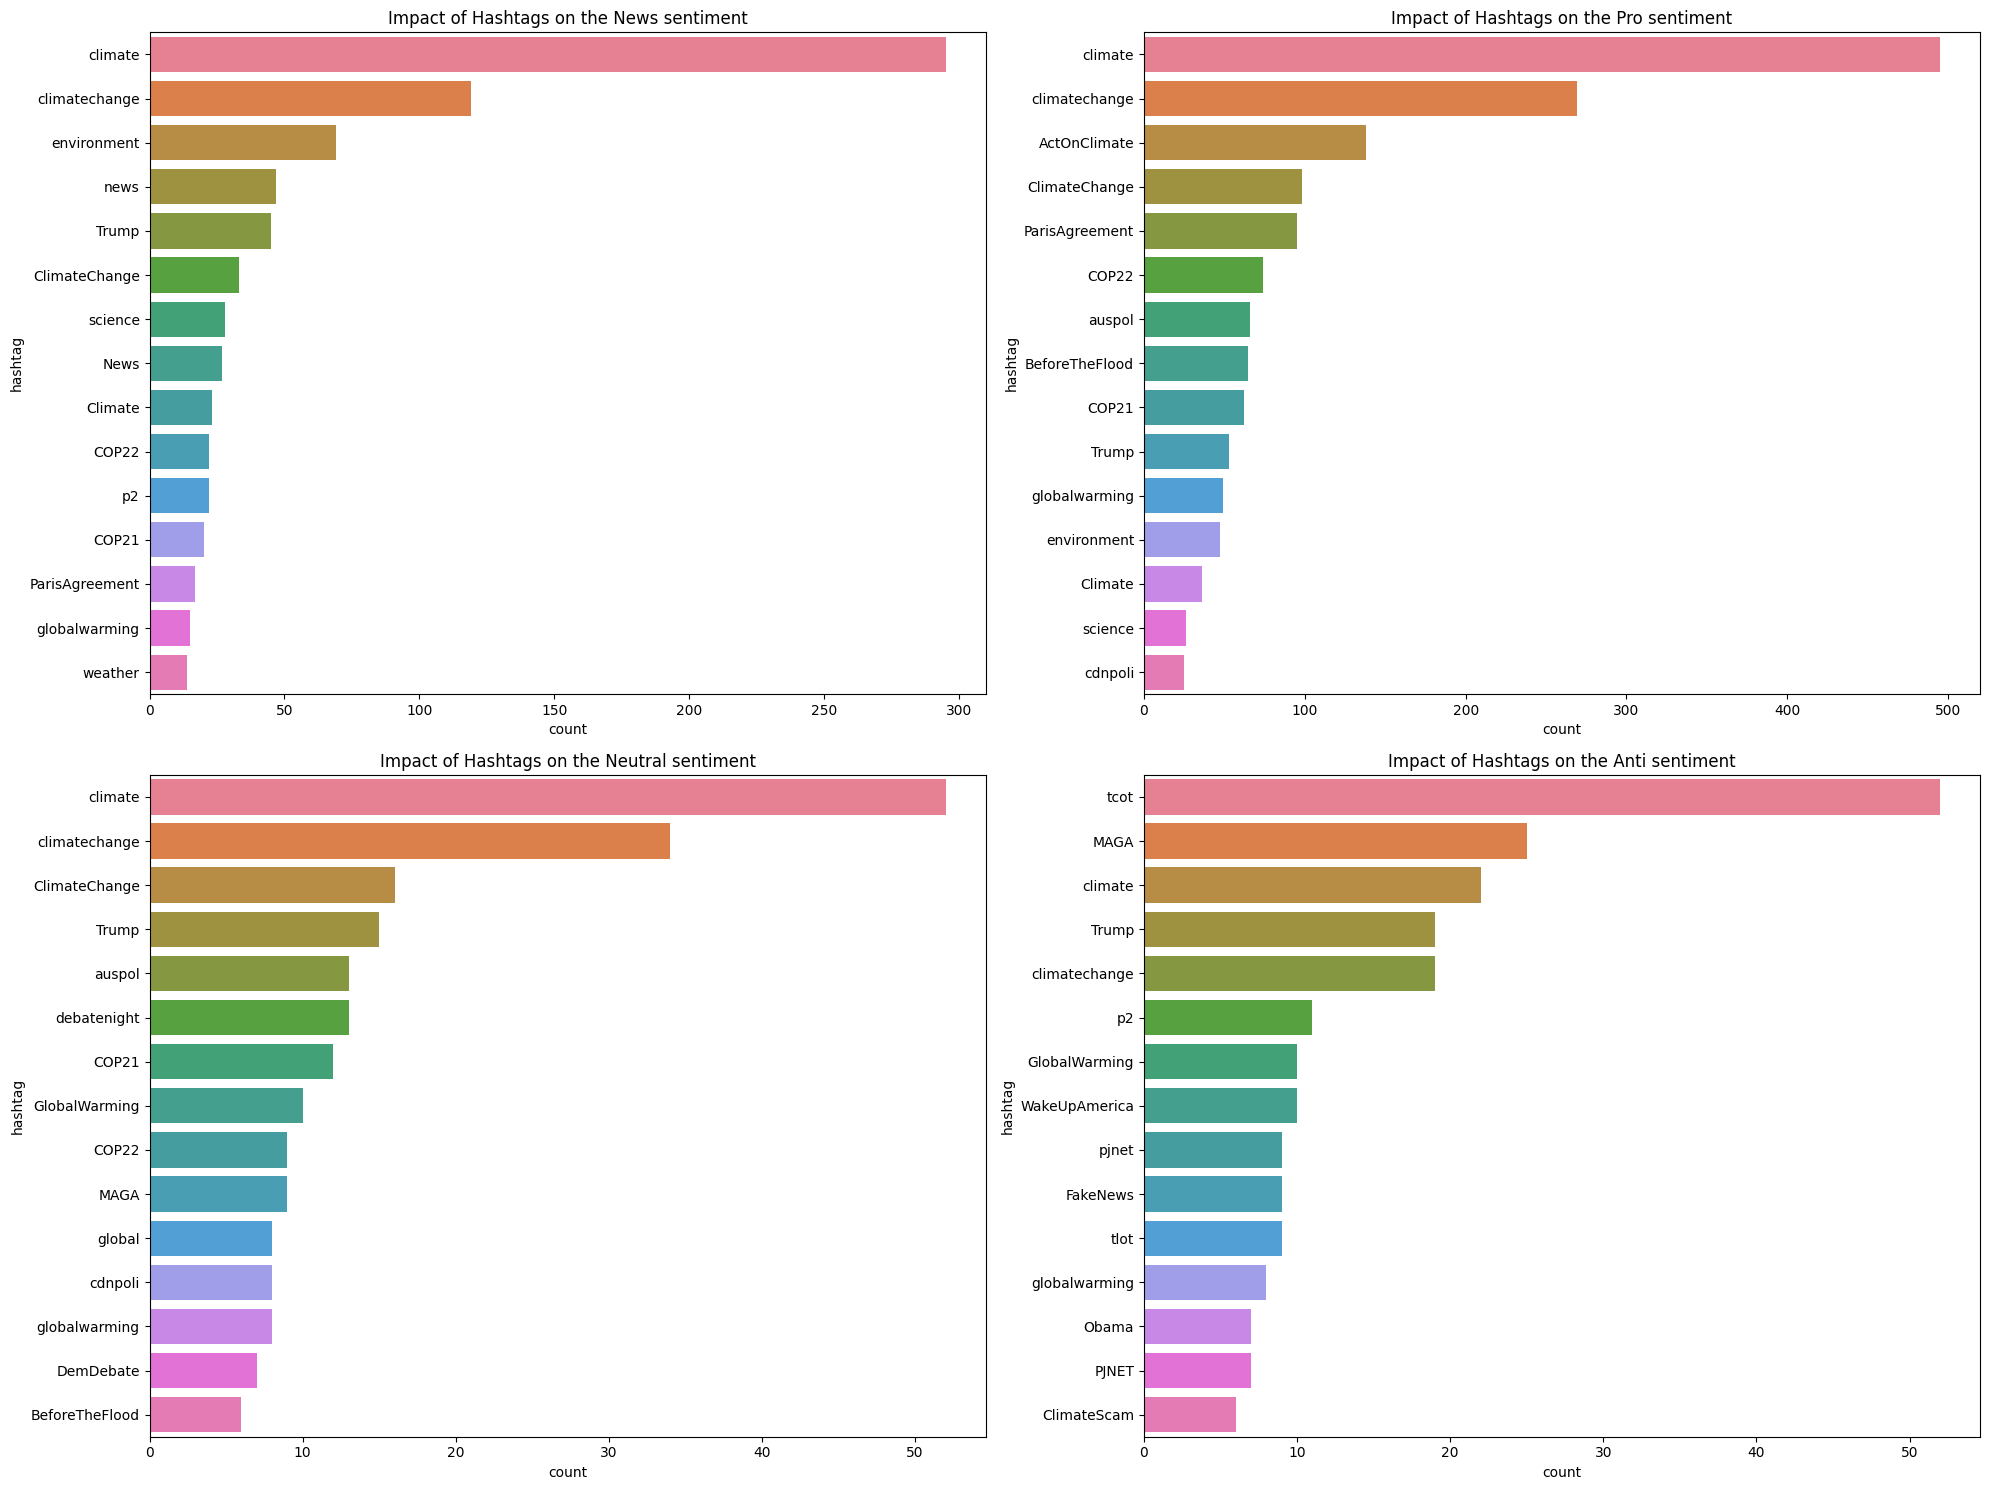

In [15]:
# Extracting hashtags from tweets
news_hashtags = extract_hashtags(df['message'][df['sentiment'] == 2])

pro_hashtags = extract_hashtags(df['message'][df['sentiment'] == 1])

neutral_hashtags = extract_hashtags(df['message'][df['sentiment'] == 0])

anti_hashtags = extract_hashtags(df['message'][df['sentiment'] == -1])

# Visualising the hashtags
full_title = ['Impact of Hashtags on the News sentiment',
              'Impact of Hashtags on the Pro sentiment',
              'Impact of Hashtags on the Neutral sentiment',
              'Impact of Hashtags on the Anti sentiment']


# Barplot of the hashtags for each category
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
for i, j in enumerate([news_hashtags, pro_hashtags, neutral_hashtags, anti_hashtags]):
    row = i // 2
    col = i % 2
    sns.barplot(x='count', y='hashtag', data=j, ax=axes[row, col], palette='husl', hue='hashtag', legend=False)
    axes[row, col].set_title(full_title[i])
    
plt.tight_layout()
plt.show()

## 2. Preprocessing

### a) Cleaning the tweet messages

Once we've done some EDA on the data, let's clean the tweet messages by removing the unnecessary entities such as *URL's*, *punctuations*, *mentions*, *numbers* and *new lines*. To this end, we will first convert all the letters to lowercase in order to normalize the data, then we remove entities that we don't need. We are going to remove them through [__Regular Expressions (RegEx)__](https://en.wikipedia.org/wiki/Regular_expression). This process uses __meta characters__ to express how to match patterns in text.

The symbol ```\w``` means "any word character" (a, ..., z) and (0, ..., 9). 
```\s``` means a white space. The brackets indicate that we take a set of character.     
```[^ ]``` matches a single character that is not contained within the brackets.   
```*``` indicates zero or more occurrences of the preceding element.   
```+``` matches the preceding element one or more times. For example, ```ab+c``` matches "abc", "abbc", "abbbc", and so on, but not "ac".   
```$``` means the ending position of the string or the position just before a string-ending newline.  

In [16]:
def clean_text(text):

    text = text.lower() # Convert to lowercase
    text = re.sub(r'@\w*', '', text)  # Removing @mentions
    text = re.sub(r'#\w*', '', text)  # Removing #hashtags
    text = re.sub(r'www\.[^\s]+|https?://[^\s]+', '', text)  # Removing hyperlinks
    text = re.sub(r'\n', '', text)  # Removing new line
    text = re.sub(r'\d+', '', text)  # Removing digits
    text = re.sub(r'\W', ' ', text)  # Removing non-word characters (\W is equivalent to [^a-zA-Z0-9_])
    text = re.sub(r'\s+', ' ', text)  # Removing extra spaces
    text = re.sub(r'^\s+|\s+?$', '', text)  # Removing extra spaces at the beginning and the ending
    
    return text


In [17]:
# Create a copy of the dataframe to avoid modifying the original dataframe
tweets = df.copy()

# Apply the clean_text function to the 'message' column
tweets['clean_tweet'] = tweets['message'].apply(clean_text)

tweets.head()

sentiment                                            message  \
0         -1  @tiniebeany climate change is an interesting h...   
1          1  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2          1  Fabulous! Leonardo #DiCaprio's film on #climat...   
3          1  RT @Mick_Fanning: Just watched this amazing do...   
4          2  RT @cnalive: Pranita Biswasi, a Lutheran from ...   

              tweetid                                        clean_tweet  
0  792927353886371840  climate change is an interesting hustle as it ...  
1  793124211518832641  rt watch right here as travels the world to ta...  
2  793124402388832256  fabulous leonardo s film on change is brillian...  
3  793124635873275904  rt just watched this amazing documentary by le...  
4  793125156185137153  rt pranita biswasi a lutheran from odisha give...

### b) Tokenization

Tokenization corresponds to the process of breaking a larger object into sub-parts, or tokens. In Natural Language Processing, tokens may vary. For instance, one may perform analysis at three levels,

- Character
- Word
- Sentence

The idea is that a sentence is a set of words, and a word is a set of characters. In this sense, the character is the atom of NLP, analogous to pixels in image processing. Nonetheless, NLP usually performs analysis at the level of words. Henceforth, we will mention "tokenization" to the process of breaking chunks of texts into its individual words. We can do so with [NLTK](https://www.nltk.org/), which is an open-source __ensemble__ of libraries, datasets and tutorials written in Python, that also constitutes a single library used in natural language processing. It was originally intended for __educational purposes__.

In [18]:
# Remove stopwords
def tweet_tokens(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    filtered_text = [word for word in tokens if word not in stop_words]
    
    return filtered_text

In [19]:
# Apply the remove_stopwords function to the 'clean_tweet' column
tweets['tweet_tokens'] = tweets['clean_tweet'].apply(tweet_tokens)

tweets.head()


sentiment                                            message  \
0         -1  @tiniebeany climate change is an interesting h...   
1          1  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2          1  Fabulous! Leonardo #DiCaprio's film on #climat...   
3          1  RT @Mick_Fanning: Just watched this amazing do...   
4          2  RT @cnalive: Pranita Biswasi, a Lutheran from ...   

              tweetid                                        clean_tweet  \
0  792927353886371840  climate change is an interesting hustle as it ...   
1  793124211518832641  rt watch right here as travels the world to ta...   
2  793124402388832256  fabulous leonardo s film on change is brillian...   
3  793124635873275904  rt just watched this amazing documentary by le...   
4  793125156185137153  rt pranita biswasi a lutheran from odisha give...   

                                        tweet_tokens  
0  [climate, change, interesting, hustle, global,...  
1  [rt, watch, right, travels, world, tackle, cli...  
2  [fabulous, leonardo, film, change, brilliant, ...  
3  [rt, watched, amazing, documentary, leonardodi...  
4  [rt, pranita, biswasi, lutheran, odisha, gives...

### c) Stemming and Lemmatization 

**Stemming** and **lemmatization** are techniques used in NLP to reduce words to their base or root form. The main difference between the two is that stemming simply chops off the ends of words to remove prefixes and suffixes, while lemmatization considers the context and meaning of words to convert them to their dictionary form.

- ```Stemming``` involves applying a set of rules to remove common word endings, such as "-s", "-ing", or "-ed". For example, the word "running" would be stemmed to "run". Stemming is a simpler and faster process compared to lemmatization, but it may result in the loss of the original word's meaning.

- ```Lemmatization```, on the other hand, uses more advanced techniques to determine the base form of a word based on its part of speech and context. It takes into account the morphological analysis of words and uses a dictionary or vocabulary to map words to their base form. For example, the word "running" would be lemmatized to "run".

In sentiment analysis, the goal is to determine the sentiment or emotion expressed in a text. Stemming is generally not recommended for sentiment analysis because it can lead to the loss of important information and context. Stemming may change the meaning of words and can result in incorrect sentiment classification. Lemmatization, on the other hand, preserves the original meaning of words and is more suitable for sentiment analysis tasks.

By using lemmatization, we can ensure that sentiment analysis models have access to the correct base forms of words, which helps in capturing the intended sentiment accurately.

In [20]:
def lemmatize_text(text):

    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text]
    
    return lemmatized_text

In [21]:
# Apply the lemmatize_text function to the 'tweet_tokens' column
tweets['lemmatized_tweet_tokens'] = tweets['tweet_tokens'].apply(lemmatize_text)
tweets['lemmatized_tweet'] = [' '.join(map(str, l)) for l in tweets['lemmatized_tweet_tokens']]
tweets.head()

sentiment                                            message  \
0         -1  @tiniebeany climate change is an interesting h...   
1          1  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2          1  Fabulous! Leonardo #DiCaprio's film on #climat...   
3          1  RT @Mick_Fanning: Just watched this amazing do...   
4          2  RT @cnalive: Pranita Biswasi, a Lutheran from ...   

              tweetid                                        clean_tweet  \
0  792927353886371840  climate change is an interesting hustle as it ...   
1  793124211518832641  rt watch right here as travels the world to ta...   
2  793124402388832256  fabulous leonardo s film on change is brillian...   
3  793124635873275904  rt just watched this amazing documentary by le...   
4  793125156185137153  rt pranita biswasi a lutheran from odisha give...   

                                        tweet_tokens  \
0  [climate, change, interesting, hustle, global,...   
1  [rt, watch, right, travels, world, tackle, cli...   
2  [fabulous, leonardo, film, change, brilliant, ...   
3  [rt, watched, amazing, documentary, leonardodi...   
4  [rt, pranita, biswasi, lutheran, odisha, gives...   

                             lemmatized_tweet_tokens  \
0  [climate, change, interesting, hustle, global,...   
1  [rt, watch, right, travel, world, tackle, clim...   
2  [fabulous, leonardo, film, change, brilliant, ...   
3  [rt, watched, amazing, documentary, leonardodi...   
4  [rt, pranita, biswasi, lutheran, odisha, give,...   

                                    lemmatized_tweet  
0  climate change interesting hustle global warmi...  
1  rt watch right travel world tackle climate cha...  
2  fabulous leonardo film change brilliant watch via  
3  rt watched amazing documentary leonardodicapri...  
4  rt pranita biswasi lutheran odisha give testim...

### d) Word Embedding (from tokens to vectors)

**Word embedding** is a technique used in NLP to represent words in a continuous vector space where the semantic meaning of words is encoded based on their context in a corpus of text.

`CountVectorizer()` and `DistilBertTokenizerFast` are tools commonly used in NLP, each serving different purposes and operating at different levels of sophistication. [CountVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) belongs to traditional bag-of-words approaches and is a simpler technique compared to [DistilBertTokenizerFast](https://huggingface.co/docs/transformers/model_doc/distilbert), which is designed for Transformer-based models like **BERT** (Bidirectional Encoder Representations from Transformers). BERT is a revolutionary deep learning model introduced by *Google* in 2018, built upon the transformer architecture. Unlike previous models, BERT is bidirectional, considering both left and right context when processing text, which enables it to capture a more comprehensive understanding of language.

`CountVectorizer()` converts a collection of text documents into a matrix of token counts, where each row represents a document and each column represents a unique token in the corpus. The values in the matrix indicate the frequency of each token in the corresponding document. However, `CountVectorizer()` does not capture the semantic meaning or context of words. It treats each word as an independent feature and does not consider word order or relationships between words.

On the other hand, `DistilBertTokenizerFast` tokenizes input text into subwords or wordpieces, which are then fed into the BERT model. Unlike `CountVectorizer()`, `DistilBertTokenizerFast` considers the context of words and captures their semantic meaning. It is based on deep learning techniques and is capable of capturing complex linguistic patterns. BERT-based models like DistilBERT have been pretrained on large text corpora and have learned contextual representations of words, which are more informative compared to traditional bag-of-words approaches.

Therefore, we will use `CountVectorizer()` to make some analysis on the tweets and for tasks like sentiment analysis, understanding the context and nuances of language is crucial so we will use the `DistilBertTokenizerFast` tokenizer.

#### &bull; Word cloud using `CountVectorizer()`

As CountVectorizer() creates a matrix of frequency of each token in the document, we can plot word clouds to see what are the most frequent words in each category (for each sentiment).

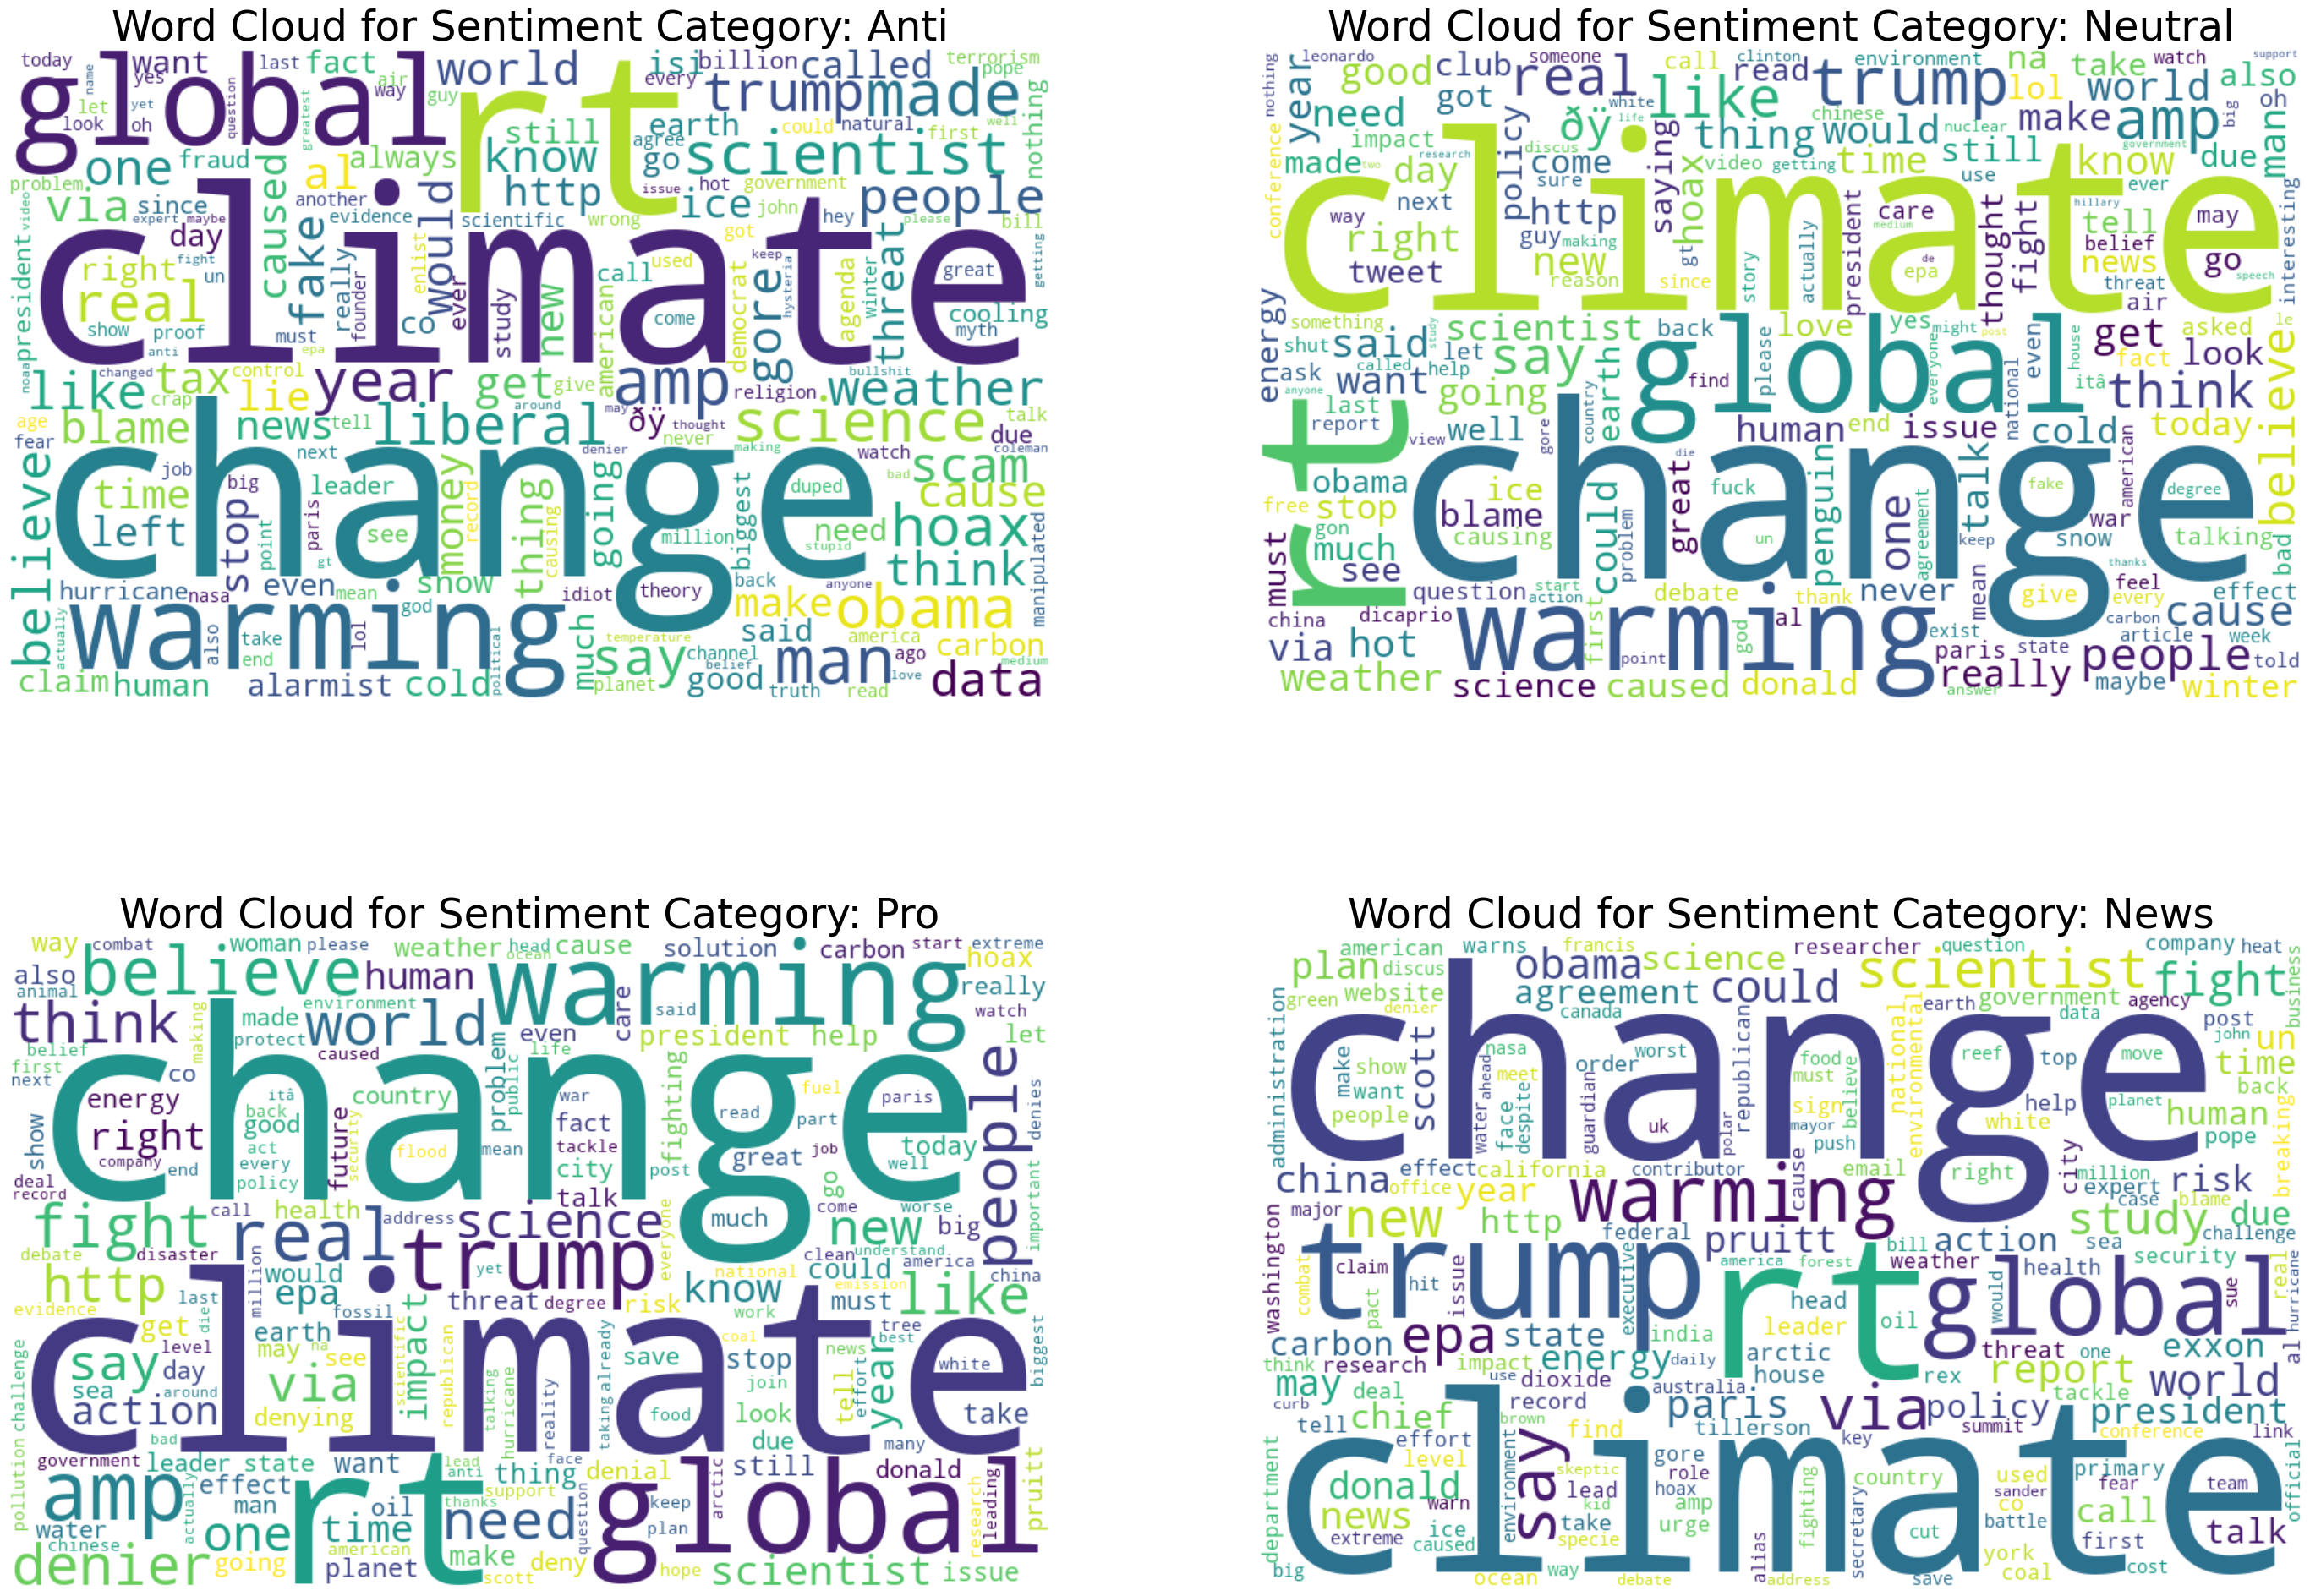

In [22]:
# Define category labels
category_labels = {-1: 'Anti', 0: 'Neutral', 1: 'Pro', 2: 'News'}

# Create subplots for each sentiment category
f, axarr = plt.subplots(2, 2, figsize=(35, 25))

# Group lemmatized tweets by sentiment categories
grouped_tweets = tweets.groupby('sentiment')

# Create word cloud for each sentiment category
for (sentiment, group), ax in zip(grouped_tweets, axarr.flatten()):
    # Count word frequencies using CountVectorizer
    cv = CountVectorizer()
    vect = cv.fit_transform(group['lemmatized_tweet'])
    
    # Get feature names (words)
    feature_names = cv.get_feature_names_out()

    # Convert sparse matrix to array and sum frequencies
    word_freq = dict(zip(feature_names, vect.toarray().sum(axis=0)))

    # Create word cloud
    wordcloud = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_freq)
    
    # Plot the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for Sentiment Category: {category_labels[sentiment]}', fontsize=35)
    ax.axis('off')

# Remove the ticks on the x and y axes
for ax in f.axes:
    ax.axis('off')

plt.show()

#### **Comments**:

#### &bull; Embedding using `DistilBertModel` and its tokenizer

As said before, the `DistilBertTokenizerFast` considers the context of words and captures their semantic meaning. Therefore, it can be really nice to convert all our tweets into vectors thanks to this model. Let's see how we will proceed.

In [23]:
# Load pre-trained DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Load pre-trained DistilBERT model
model_BERT = DistilBertModel.from_pretrained('distilbert-base-uncased')


Processing texts in batches rather than one at a time significantly improves efficiency. The size of each batch will depend on your hardware's memory capacity; larger batches will decrease processing time but require more memory. Here, we decided to set `batch_size` at 32.

In [24]:
def batch_encode(texts, batch_size=32):
    # This function will handle the batching
    input_ids = []
    attention_masks = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encoded_dict = tokenizer.batch_encode_plus(
            batch,
            add_special_tokens=True,
            max_length=64,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Concatenate all batches together
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

After encoding, pass the tokens through DistilBERT to obtain the embeddings. Here, we choosed to use a mean pooling on the output of the last hidden state.

In [25]:
def extract_embeddings(input_ids, attention_masks):
    # Forward pass, get model output
    with torch.no_grad():
        outputs = model_BERT(input_ids, attention_mask=attention_masks)
    
    # Extract the last hidden states
    last_hidden_states = outputs.last_hidden_state
    
    # Average the token embeddings to get a single vector for each text input
    embeddings = torch.mean(last_hidden_states, dim=1)
    return embeddings

Then we apply this embedding on our data. Firstly, we apply this embedding on 1000 messages to check this embedding. 

In [26]:
sample_text = tweets['clean_tweet'].tolist()[:1000]
input_ids, attention_masks = batch_encode(sample_text)
embeddings_bert = extract_embeddings(input_ids, attention_masks)

# Convert embeddings into a numpy array for sklearn compatibility
embeddings_np = embeddings_bert.numpy()
print(embeddings_np.shape)

(1000, 768)


DistilBERT, like other Transformer models, runs much faster on GPUs. On a CPU, processing tens of thousands of sentences might take a substantial amount of time (potentially hours), while a GPU could handle the same task in a fraction of that time.

Indeed, for only 1000 messages, it tooks almost 1min to execute the code. Therefore, we have to find another method to embed the tweets we want to fill into the Machine Learning models.


#### &bull; `Word2Vec` embedding

[Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) is a classic method for generating word embeddings that capture semantic meanings based on the context in which words appear. The Word2Vec algorithms include skip-gram and CBOW models, using either hierarchical softmax or negative sampling. For more information, you can check the documentation of Word2Vec on Gensim website at [https://radimrehurek.com/gensim/models/word2vec.html](https://radimrehurek.com/gensim/models/word2vec.html) or you can see this article from GeeksforGeeks [https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/](https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/). This last article was very helpful to understand Word2Vec!

In [27]:
# Train a Word2Vec model
model = Word2Vec(sentences=tweets['lemmatized_tweet_tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Save the model for later use
model.save("twitter_word2vec.model")

# Function to get a sentence embedding by averaging word vectors
def get_sentence_embedding(tokens, model):
    # Get word vectors, ignoring words that aren't in the model's vocabulary
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    # Handle cases where the sentence may not have any words in the model's vocab
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        # Average the word vectors
        return np.mean(vectors, axis=0)

In [28]:
# Calculate embeddings for each sentence
embeddings = [get_sentence_embedding(sentence, model) for sentence in tweets['lemmatized_tweet_tokens'] if isinstance(sentence, list)]
embeddings = np.array(embeddings)

print(embeddings)

[[-0.66467816  0.06619947 -0.2295631  ... -0.50653893  0.28180277
   0.21611591]
 [-0.31410244 -0.34356883  0.04010136 ... -0.64848238  0.25975585
   0.43262091]
 [-0.34625834 -0.058184    0.0144904  ... -0.51835209  0.06069776
   0.34685969]
 ...
 [-0.32434165 -0.00158215  0.07718208 ... -0.67788529  0.15721308
   0.33550063]
 [-0.47081417 -0.09424044 -0.21359119 ... -0.55753404  0.06109275
   0.09931919]
 [-0.38703695 -0.19344144  0.09118728 ... -0.71725196  0.14796092
   0.26611027]]


This NLP part was really interesting and it took me a lot of time but I have learned many thinks from exploring the [Regular expressions](https://en.wikipedia.org/wiki/Regular_expression) to discovering various models and techniques to capture semantic meanings of a word based on the context. I am really interested in Transformers and NLP so I spent some time to really understand the various techniques.

Now, that we have our embeddings, let's try to predict sentiment thanks to ML models!

## 3. Model Training and Evaluation

In this section, we train several machine learning models to predict sentiment based on tweet embeddings generated from Word2Vec. We compare their performance using accuracy and cross-validated scores to select the most effective model. This approach helps ensure that our findings are robust and generalize well to unseen data.


We first randomly split the data into train (80%) and test (20%) sets. This is done using a dedicated scikit-learn function (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [29]:
# Assuming 'embeddings' is a list or array of embeddings and 'data['sentiment']' is the target
X_train, X_test, y_train, y_test = train_test_split(embeddings, tweets['sentiment'], test_size=0.2, random_state=42)

print('Train set: data set size =', X_train.shape[0], 'and target set size =', y_train.shape[0])
print('Test set: data set size =', X_test.shape[0])

Train set: data set size = 32832 and target set size = 32832
Test set: data set size = 8209


In [30]:
min_value_train = np.min(X_train)
min_value_test = np.min(X_test)
max_value_train = np.max(X_train)
max_value_test = np.max(X_test)

print("Minimum and maximum value of X_train:", min_value_train, max_value_train)
print("Minimum and maximum value of X_test:", min_value_test, max_value_test)


Minimum and maximum value of X_train: -2.050909996032715 2.000229597091675
Minimum and maximum value of X_test: -1.945275068283081 1.951804518699646


Usually we normalize or standartize the data however for embeddings generated by pre-trained models like Word2Vec, the embeddings often already incorporate a form of scaling or normalization during their training process. Further scaling or normalization might not be necessary and could potentially distort the embeddings.

### **Multiclass Logistic Regression**

To perform our classification, we will use the logistic regression model for a given value of the regularization parameter. We will first look at the result with no regularization.

#### No regularization (no penalty)

In [31]:
# Train and evaluate models
# We set class_weight as 'balanced' because it uses the values of y to automatically adjust weights inversely proportional to 
# class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
# We saw that the distribution of our dataset is very imbalanced, so we use this parameter to balance the classes.
clf1 = LogisticRegression(class_weight='balanced', multi_class='multinomial', penalty=None, solver='lbfgs', max_iter=10000)
clf2 = LogisticRegression(class_weight='balanced', multi_class='multinomial', penalty=None, solver='saga', max_iter=10000)

weights = {-1: 2.0, 0: 1.5, 1: 1.0, 2: 1.5}
clf1_weights = LogisticRegression(class_weight=weights, multi_class='multinomial', penalty=None, solver='lbfgs', max_iter=10000)
clf2_weights = LogisticRegression(class_weight=weights, multi_class='multinomial', penalty=None, solver='saga', max_iter=10000)

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf1_weights.fit(X_train, y_train)
clf2_weights.fit(X_train, y_train)

score1 = clf1.score(X_test, y_test) 
score2 = clf2.score(X_test, y_test)
score1_weights = clf1_weights.score(X_test, y_test)
score2_weights = clf2_weights.score(X_test, y_test) 

print('Multinomial Logistic Regression Accuracy without CV and regularization, solver=lbfgs:', score1)
print('Multinomial Logistic Regression Accuracy without CV and regularization, solver=saga:', score2, '\n')
print('Multinomial Logistic Regression Accuracy with custom class weights and without regularization, solver=lbfgs:', score1_weights)
print('Multinomial Logistic Regression Accuracy with custom class weights and without regularization, solver=saga:', score2_weights)

Multinomial Logistic Regression Accuracy without CV and regularization, solver=lbfgs: 0.5191862589840419
Multinomial Logistic Regression Accuracy without CV and regularization, solver=saga: 0.5194298940187599 

Multinomial Logistic Regression Accuracy with custom class weights and without regularization, solver=lbfgs: 0.5959312949202096
Multinomial Logistic Regression Accuracy with custom class weights and without regularization, solver=saga: 0.5959312949202096


We have a better accuracy when using our custom class weight. Therefore, we will use this class weight for the rest of the project.

#### Lasso Regression (l1 penalty)

In [32]:
# Train and evaluate models
clf = LogisticRegression(class_weight=weights, multi_class='multinomial', penalty='l1', solver='saga', max_iter=10000)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print('Multinomial Logistic Regression Accuracy with l1 penalty and without CV, solver=saga:', score)

Multinomial Logistic Regression Accuracy with l1 penalty and without CV, solver=saga: 0.6014130832013643


#### Ridge Regression (l2 penalty)

In [33]:
# Train and evaluate models
clf1 = LogisticRegression(C=10, class_weight=weights, multi_class='multinomial', penalty='l2', solver='lbfgs', max_iter=10000)
clf2 = LogisticRegression(C=10, class_weight=weights, multi_class='multinomial', penalty='l2', solver='saga', max_iter=10000)

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)

score1 = clf1.score(X_test, y_test)
score2 = clf2.score(X_test, y_test)
print('Multinomial Logistic Regression Accuracy with l2 penlaty without CV, solver=lbfgs:', score1)
print('Multinomial Logistic Regression Accuracy with l2 penlaty without CV, solver=saga:', score2)

Multinomial Logistic Regression Accuracy with l2 penlaty without CV, solver=lbfgs: 0.6001949080277744
Multinomial Logistic Regression Accuracy with l2 penlaty without CV, solver=saga: 0.6003167255451334


Overall, we notice that we have the best result for l1 regularization term with the solver `saga`. Let's see the [learning curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html).

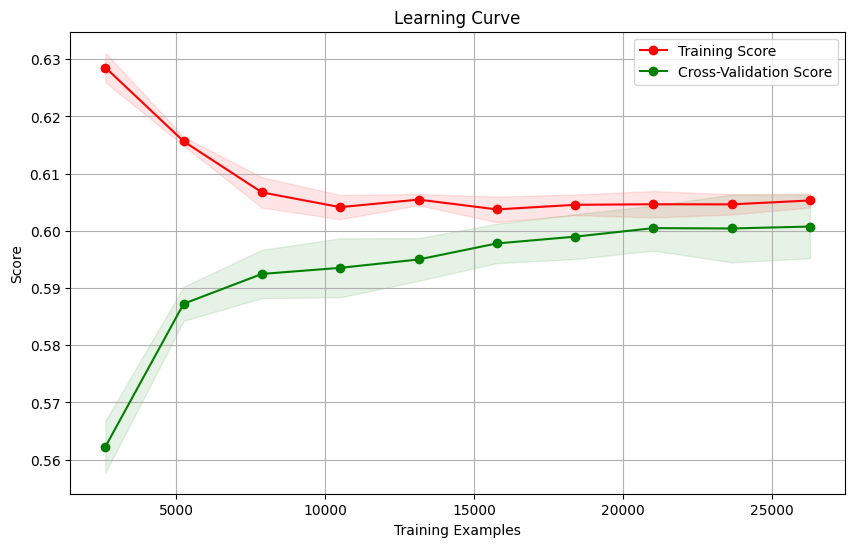

In [34]:
# Define your model
model = LogisticRegression(class_weight=weights, multi_class='multinomial', penalty=None, solver='lbfgs', max_iter=10000)

# Define the learning curve parameters
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.legend(loc='best')
plt.show()


Both the training and cross-validation scores converge to a value that is not particularly high, suggesting the model might have high bias or is underfitting. The model's performance does not improve significantly with more data, indicating it may be too simple to capture the complexity of the dataset.

#### Cross Validation

Now, let's compare with a logistic regression that includes a cross validation. We will do a cross validation into the model using the built in function https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html.

In [36]:
# Train and evaluate models
# The solver 'lbfgs' is suitable for large datasets and multinomial loss
# model_logReg = LogisticRegressionCV(cv=5, class_weight=weights, multi_class='multinomial', penalty='l2', solver='lbfgs', max_iter=10000)
model_logReg2 = LogisticRegressionCV(cv=5, class_weight=weights, multi_class='multinomial', penalty='l2', solver='saga', max_iter=10000)

# fit data
model_logReg.fit(X_train, y_train)

accuracy = model_logReg.score(X_test, y_test)
print(f"Multinomial Logistic Regression Accuracy with CV: {accuracy}")

Multinomial Logistic Regression Accuracy with CV: 0.5975149226458765


We could also use `GridSearchCV` to find the best parameters.

In [38]:
# Define the model parameters to include both L1 and L2 regularization
param_grid = {
    'C': np.logspace(-3, 3, 7)  # Creates 7 values for C, logarithmically spaced between 10^-4 and 10^4
    # 'penalty': ['l1', 'l2']  # L1 is Lasso, L2 is Ridge (it was too long so I decided to keep 'l2' the penalty by default)
}

# Configure the logistic regression model
# Note: The 'liblinear' solver works well with L1 and L2 penalties for small to medium datasets
log_reg = LogisticRegression(class_weight=weights, multi_class='multinomial', solver='saga', max_iter=10000)

# Setup the grid search with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, verbose=1, scoring='accuracy')

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best logistic regression model
best_model = grid_search.best_estimator_

# Calculate accuracy and display the classification report
accuracy = best_model.score(X_test, y_test)
print(f"Best Model Accuracy: {accuracy}")
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Model Accuracy: 0.5971494700937995
Best Parameters: {'C': 100.0}


We can analyse the results by looking at the confusion matrix, see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html In the $i$ th line, we represent the predicted labels for the class labeled as $i-1$ (-1, 0, 1, 2) in the dataset.

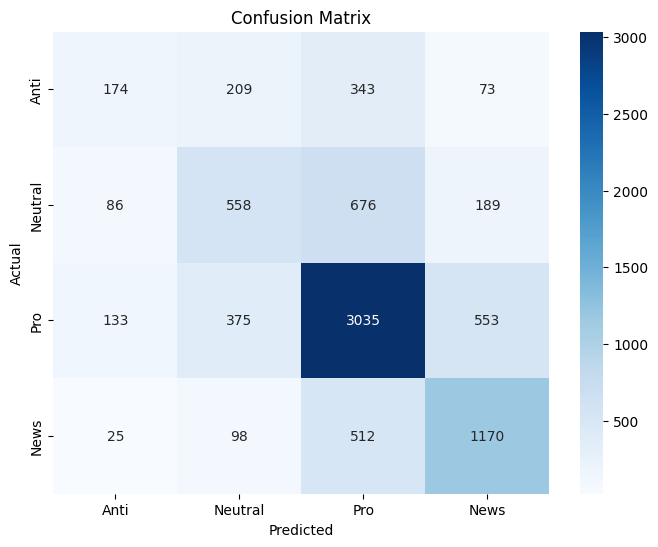

Classification report: 
               precision    recall  f1-score   support

        Anti       0.42      0.22      0.29       799
     Neutral       0.45      0.37      0.41      1509
         Pro       0.66      0.74      0.70      4096
        News       0.59      0.65      0.62      1805

    accuracy                           0.60      8209
   macro avg       0.53      0.49      0.50      8209
weighted avg       0.58      0.60      0.59      8209



In [40]:
from sklearn import metrics

y_pred = clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=[-1, 0, 1, 2])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anti', 'Neutral', 'Pro', 'News'], yticklabels=['Anti', 'Neutral', 'Pro', 'News'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# print the classification report
clf_report = metrics.classification_report(y_test, y_pred, target_names=['Anti', 'Neutral', 'Pro', 'News'])
print('Classification report: \n', clf_report)

The classifier is most effective at identifying **Pro** tweets, with the highest recall and a good precision and **anti** tweets have the lowest recall, indicating many are misclassified as other categories, and a moderate precision.

Given that half of the messages in the dataset are "Pro", followed by "News" (22%), "Neutral" (18%), and "Anti" (10%), the model demonstrates a strong bias towards the "Pro" category, achieving the highest recall in this category. This imbalance likely causes the model to be particularly tuned to the patterns and language prevalent in "Pro" messages, at the expense of the other categories, especially "Anti", which not only has the smallest proportion but also shows poor recall and precision.

Therefore we have imposed a custom class weight in the model that doubles the weight for "Anti" and increase by 50% for "Neutral" and "News". In this way, we obtain a better precision per category as before (with no class weight) and a better f1-score (better compared to the one using balanced class weight).

Let's check at some missclassified tweets.

In [41]:
index = 0
missclassifiedIndices = []
for label, predict in zip(y_test, y_pred):
   if (label != predict):
      missclassifiedIndices.append(index)
   index +=1

category_labels = ['Anti', 'Neutral', 'Pro', 'News']

# print missclassified tweets
print('Missclassified tweets:')
for index in missclassifiedIndices[:5]:
   print('Actual:', category_labels[tweets['sentiment'].iloc[index]+1], ', Predicted:', category_labels[y_pred[index]],', tweet:', tweets['message'].iloc[index], '\n')



Missclassified tweets:
Actual: Pro , Predicted: Neutral , tweet: Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube 

Actual: News , Predicted: Neutral , tweet: RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦ 

Actual: Pro , Predicted: Anti , tweet: #BeforeTheFlood Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change... https://t.co/HCIZrPUhLF 

Actual: Pro , Predicted: Neutral , tweet: Bangladesh did not cause climate change, so the country does not need Ã¢â‚¬Å“aidÃ¢â‚¬ï†; instead it needs compensation for theÃ¢â‚¬Â¦ https://t.co/ecGXgRNROP 

Actual: Neutral , Predicted: Pro , tweet: National GeographicÃ¢â‚¬â„¢s climate change documentary with Leonardo DiCaprio is now on YouTube https://t.co/1Y3koz4KDY via @thenextweb 



### **SVM**

The reference page on scikit-learn for SVM is https://scikit-learn.org/stable/modules/svm.html.

In [43]:
weights = {-1:2, 0:1.5, 1:1, 2:1.5}
svm_clf_basic = SVC(C=10, kernel='rbf', class_weight=weights)
svm_clf_basic.fit(X_train, y_train)

# Predict the test set
y_pred_svm = svm_clf_basic.predict(X_test)

# Calculate the accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('SVM Accuracy:', accuracy_svm)

# Print the classification report
clf_report_svm = classification_report(y_test, y_pred_svm, target_names=['Anti', 'Neutral', 'Pro', 'News'])
print('Classification report: \n', clf_report_svm)

SVM Accuracy: 0.6182239005969058
Classification report: 
               precision    recall  f1-score   support

        Anti       0.46      0.26      0.33       799
     Neutral       0.51      0.34      0.41      1509
         Pro       0.66      0.78      0.71      4096
        News       0.61      0.65      0.63      1805

    accuracy                           0.62      8209
   macro avg       0.56      0.51      0.52      8209
weighted avg       0.60      0.62      0.60      8209



We have a better accuracy using SVM instead of Multinomial Logistic Regression! Let's still improve the performances using Cross Validation to find the best parameters.

In [42]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100]  # Example values for regularization parameter
}

# Initialize the SVM classifier
svm = SVC()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
y_pred = best_model.predict(X_test)
print("Test set accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
from mlxtend.plotting import plot_decision_regions

# Plot the decision regions
plot_decision_regions(X_train, y_train, clf=best_model, legend=2)

# Add axis labels and a title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Classification with Boundaries')

# Show the plot
plt.show()


### **Decision Trees and Random Forests**


We start by performing regression with a single tree. See https://scikit-learn.org/stable/modules/tree.html for a presentation of trees in Scikit-learn, as well as https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html for a description of the various functions in the class.

First of all, let's see what accuracy gives the DecisionTreeClassifier with default parameters.


In [49]:
# choice of parameters 
chosen_max_depth = 4
chosen_min_samples_leaf = 5

# constructing + fitting the model and making the prediction
dt = DecisionTreeClassifier(max_depth=chosen_max_depth, min_samples_leaf=chosen_min_samples_leaf, random_state=my_seed) 
model = dt.fit(X_train,y_train)
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy}")

# print the classification report
clf_report = metrics.classification_report(y_test, y_pred, target_names=['Anti', 'Neutral', 'Pro', 'News'])
print('Classification report: \n', clf_report)


Decision Tree Accuracy: 0.546838835424534
Classification report: 
               precision    recall  f1-score   support

        Anti       0.00      0.00      0.00       799
     Neutral       0.48      0.16      0.24      1509
         Pro       0.56      0.86      0.68      4096
        News       0.52      0.41      0.46      1805

    accuracy                           0.55      8209
   macro avg       0.39      0.36      0.34      8209
weighted avg       0.48      0.55      0.48      8209



c:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

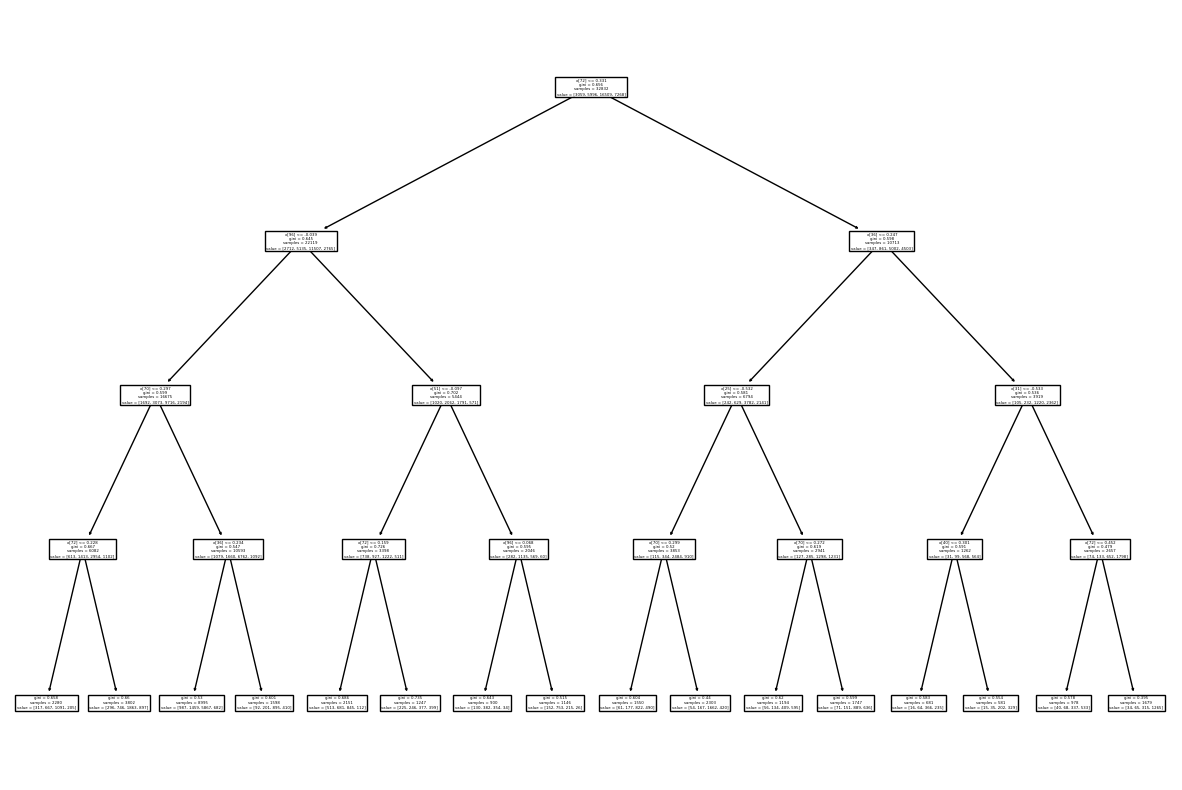

In [50]:
plt.figure(figsize=(15, 10))
plot_tree(dt)
plt.show()

In [56]:
# choice of parameters 
chosen_max_depth = 10
chosen_min_samples_leaf = 2

# constructing + fitting the model and making the prediction
dt = DecisionTreeClassifier(max_depth=chosen_max_depth, min_samples_leaf=chosen_min_samples_leaf, random_state=my_seed) 
model = dt.fit(X_train,y_train)
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy}")

# print the classification report
clf_report = metrics.classification_report(y_test, y_pred, target_names=['Anti', 'Neutral', 'Pro', 'News'])
print('Classification report: \n', clf_report)


Decision Tree Accuracy: 0.5629187477159215
Classification report: 
               precision    recall  f1-score   support

        Anti       0.33      0.12      0.17       799
     Neutral       0.43      0.28      0.34      1509
         Pro       0.60      0.79      0.68      4096
        News       0.56      0.49      0.52      1805

    accuracy                           0.56      8209
   macro avg       0.48      0.42      0.43      8209
weighted avg       0.53      0.56      0.53      8209



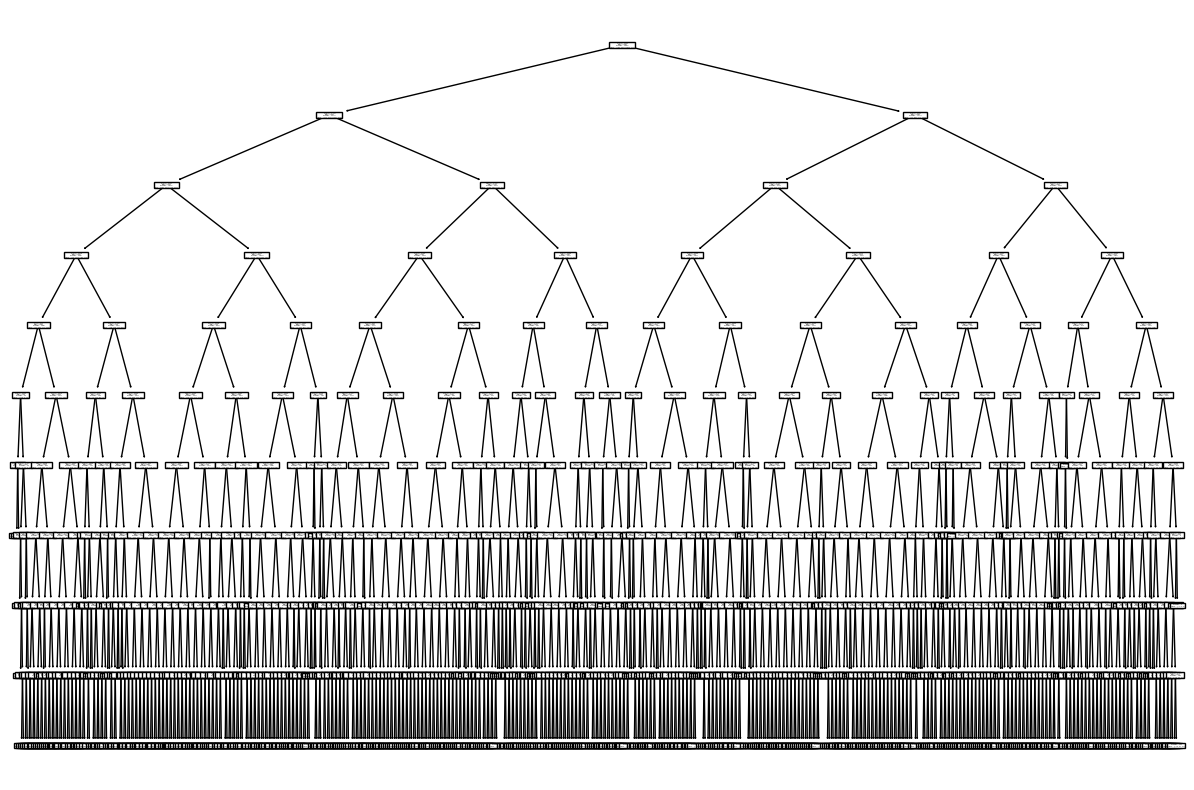

In [57]:
plt.figure(figsize=(15, 10))
plot_tree(dt)
plt.show()

Now we will try to find the best hyperparameters for the model and then retrain the corresponding model and compute the associated outputs using Cross Validation.

In [ ]:
# Define the parameter grid including min_weight_fraction_leaf
param_grid = {
    'criteria': ['gini', 'entropy'],  # 'gini' for Gini impurity, 'entropy' for information gain
    'splitter': ['best', 'random'],  # 'best' to choose the best split, 'random' to choose the best random split
    'max_depth': [ 5, 10,20,50,100],
    'min_samples_leaf': [3,4,5,7,10,15,20]
}

# Create a decision tree regressor
tree = DecisionTreeClassifier()

# Create GridSearchCV object with cross-validation (e.g., 5-fold)
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X, y)
a = grid_search.best_params_
# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Print the best score (negative mean squared error)
print("Best Score:", -grid_search.best_score_)


In [ ]:
# training with best parameters
dt_final = DecisionTreeClassifier(max_depth=a['max_depth'], min_samples_leaf=a['min_samples_leaf'], random_state=my_seed)
model = dt_final.fit(X_train,y_train)
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy}")

# print the classification report
clf_report = metrics.classification_report(y_test, y_pred, target_names=['Anti', 'Neutral', 'Pro', 'News'])
print('Classification report: \n', clf_report)

### **XGBoost**